# Lecture 5 coding

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# import scikit learn libraries
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor# you may need to install XGBoost
from sklearn.metrics import r2_score,mean_absolute_error, mean_squared_error
from yellowbrick.model_selection import learning_curve

# helpers
from src.helpers import feature_importance_plot

import warnings
warnings.filterwarnings('ignore')


In [46]:
class EDA:
    def __init__(self, csv_file):
        self.target_type = None
        self.target_var = None
        self.df = pd.read_csv(csv_file)
        self.rows = self.df.shape[0]
        self.cols = self.df.shape[1]

    def __repr__(self):
        return f"A dataframe with {self.rows} rows and {self.cols} columns"

    def summary(self):
        self.print_header("Info")
        print(self.df.info())

        self.print_header("Sample rows")
        print(self.df.sample(10))

        self.print_header("Description")
        print(self.df.describe())

        self.print_header("Standard deviation")
        print(self.df.std())

    def info(self):
        self.df.info()

    def describe(self, include="all"):
        self.df.describe(datetime_is_numeric=True, include=include)

    def std(self):
        self.df.std()

    def print_header(self, title, sep="__", n_sep=15):
        return print(f'{sep * n_sep} {title} {sep * n_sep} \n')

    def target(self, target_name: str, target_type:str) -> None:
        """
        Sets the target variable
        :param target_name: Name of target variable in dataset
        :param target_type: Type of variable cat, contin
        :return:
        """
        try:
            self.target_var = self.df[target_name]
            self.target_type = target_type
        except KeyError:
            raise KeyError("Target variable not in Dataset")

    def plot_target(self):
        """
        Plots distribution of the target variable
        :return:
        """
        if self.target_type == "cat":
            self.target_var.value_counts().plot(kind="bar")
            plt.title("Distribution of target variable")
        else:
            self.target_var.hist()

    def identify_correlations(self):
        corr = self.df.corr()
        corr.style.background_gradient(cmap='coolwarm')
        sns.heatmap(corr)

    def num_cats(self):
        try:
            cat_features = self.df.select_dtypes("object").nunique(dropna=False).sort_values(ascending=False)
            return cat_features
        except TypeError as e:
            raise TypeError("No categorical variables")

    def remove_cats(self, n_cats):
        num_cats = self.num_cats()

        print(num_cats > n_cats)

    def identify_low_variance(self, treshhold=0.2):
        variance = self.std()

        return variance

    # @target.setter
    # def target(self, target_name):
    #     self.target = target_name
    #

    def identify_missing_data(self):
        """
        This function is used to identify missing data

        @param df pandas DataFrame

        @return a DataFrame with the percentage of missing data for every feature and the data types
        """

        percent_missing = self.df.isnull().mean()

        missing_value_df = pd.DataFrame(percent_missing).reset_index()  # convert to DataFrame
        missing_value_df = missing_value_df.rename(columns={"index": "feature",
                                                            0: "percent_missing"})  # rename columns

        missing_value_df = missing_value_df.sort_values(by=['percent_missing'], ascending=False)  # sort the values

        data_types_df = pd.DataFrame(self.df.dtypes).reset_index().rename(columns={"index": "feature",
                                                                                   0: "data_type"})  # rename columns

        missing_value_df = missing_value_df.merge(data_types_df, on="feature")  # join the dataframe with datatype

        missing_value_df.percent_missing = round(missing_value_df.percent_missing * 100, 2)  # format the percent_missing

        return missing_value_df

    def remove_missing_data(self, threshold=0.6):
        df_missing = self.identify_missing_data()
        missing_cols = df_missing[df_missing["percent_missing"] >= threshold * 100]

        print(f"Removed the following columns {','.join(missing_cols['feature'].to_list())} due to missing data beigh higher than {threshold}")
        return self.df.drop(columns=missing_cols["feature"].tolist())





In [36]:
heart_attack_df = pd.read_csv("../data/../data/heart_attack_data.csv")
heart_attack_df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,28,1,2,130.0,132.0,0.0,2.0,185.0,0.0,0.0,NaN,NaN,NaN,0
1,29,1,2,120.0,243.0,0.0,0.0,160.0,0.0,0.0,NaN,NaN,NaN,0
2,29,1,2,140.0,NaN,0.0,0.0,170.0,0.0,0.0,NaN,NaN,NaN,0
3,30,0,1,170.0,237.0,0.0,1.0,170.0,0.0,0.0,NaN,NaN,6.0,0
4,31,0,2,100.0,219.0,0.0,1.0,150.0,0.0,0.0,NaN,NaN,NaN,0


In [44]:
heart_attack = EDA("../data/../data/heart_attack_data.csv")
heart_attack.target("target", target_type="cat")

In [9]:
heart_attack.summary()

______________________________ Info ______________________________ 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       294 non-null    int64  
 1   sex       294 non-null    int64  
 2   cp        294 non-null    int64  
 3   trestbps  293 non-null    float64
 4   chol      271 non-null    float64
 5   fbs       286 non-null    float64
 6   restecg   293 non-null    float64
 7   thalach   293 non-null    float64
 8   exang     293 non-null    float64
 9   oldpeak   294 non-null    float64
 10  slope     104 non-null    float64
 11  ca        3 non-null      float64
 12  thal      28 non-null     float64
 13  target    294 non-null    int64  
dtypes: float64(10), int64(4)
memory usage: 32.3 KB
None
______________________________ Sample rows ______________________________ 

     age  sex  cp  trestbps   chol  fbs  restecg  thalach  exang  old

In [34]:
heart_attack.identify_missing_data()

,feature,percent_missing,data_type
0,ca,98.98,float64
1,thal,90.48,float64
2,slope,64.63,float64
3,chol,7.82,float64
4,fbs,2.72,float64
5,trestbps,0.34,float64
6,restecg,0.34,float64
7,thalach,0.34,float64
8,exang,0.34,float64
9,age,0.00,int64


In [35]:
heart_attack.remove_missing_data()

Removed the following columns ca,thal,slope due to missing data beigh higher than 0.6


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,target
0,28,1,2,130.0,132.0,0.0,2.0,185.0,0.0,0.0,0
1,29,1,2,120.0,243.0,0.0,0.0,160.0,0.0,0.0,0
2,29,1,2,140.0,NaN,0.0,0.0,170.0,0.0,0.0,0
3,30,0,1,170.0,237.0,0.0,1.0,170.0,0.0,0.0,0
4,31,0,2,100.0,219.0,0.0,1.0,150.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...
289,52,1,4,160.0,331.0,0.0,0.0,94.0,1.0,2.5,1
290,54,0,3,130.0,294.0,0.0,1.0,100.0,1.0,0.0,1
291,56,1,4,155.0,342.0,1.0,0.0,150.0,1.0,3.0,1
292,58,0,2,180.0,393.0,0.0,0.0,110.0,1.0,1.0,1


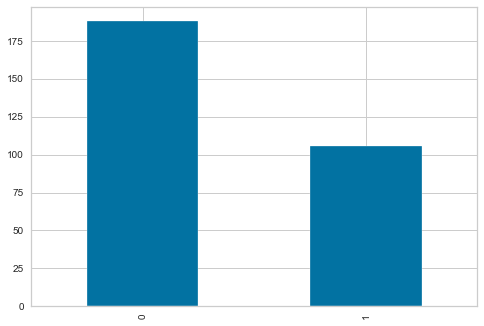

In [41]:
heart_attack.plot_target()

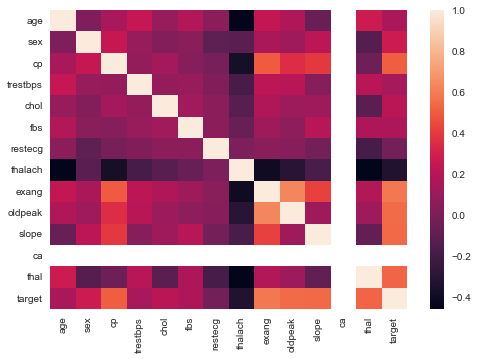

In [45]:
heart_attack.identify_correlations()